In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from ensembles import *
from sklearn.datasets import make_regression
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import minimize_scalar
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('./train_data.csv')
target = pd.read_csv('./train_target.csv')

In [3]:
data.head()

,index,id,date,bedrooms_number,batchrooms_number,square_footage_home,square_footage_lot,floors_number,has_waterfront,has_been_viewed,condition_quality,housing_unity_grade,square_footage_except_basement,square_footage_only_basement,build_year,renovation_year,coordinate_latitude,coordinate_longitude,square_footage_home_old,square_footage_lot_old
0,0,16530,2014-05-02,2,2.00,1350,2560,1.0,0,0,3,8,1350,0,1976,0,200.6344,4.893,1790,2560
1,1,3651,2014-05-02,3,1.75,1800,23103,1.0,0,0,3,7,1800,0,1968,0,200.6517,5.094,1410,18163
2,2,13568,2014-05-02,3,1.75,2240,10578,2.0,0,0,5,8,1550,690,1923,0,200.6954,4.708,1570,10578
3,3,20352,2014-05-02,4,2.00,1820,5000,1.5,0,1,3,7,1640,180,1945,0,200.6815,4.731,2060,5000
4,4,10524,2014-05-02,4,1.75,1560,8700,1.0,0,0,4,7,1560,0,1967,0,200.7274,4.819,2080,8000


In [4]:
data.dtypes

index                               int64
id                                  int64
date                               object
bedrooms_number                     int64
batchrooms_number                 float64
square_footage_home                 int64
square_footage_lot                  int64
floors_number                     float64
has_waterfront                      int64
has_been_viewed                     int64
condition_quality                   int64
housing_unity_grade                 int64
square_footage_except_basement      int64
square_footage_only_basement        int64
build_year                          int64
renovation_year                     int64
coordinate_latitude               float64
coordinate_longitude              float64
square_footage_home_old             int64
square_footage_lot_old              int64
dtype: object

Выбросим дату, id и index

In [5]:
data.drop(columns=['index', 'id', 'date'], inplace=True)

In [6]:
target.head()

,index,price
0,0,340.0
1,1,289.0
2,2,755.0
3,3,655.0
4,4,387.5


In [7]:
data = data.values
target = target['price'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42, test_size=0.2)

## Случайный лес

Базовая модель

In [62]:
rf = RandomForestMSE(n_estimators=100, max_depth=10)

In [63]:
%%time
rf.fit(X_train, y_train)

Wall time: 2.49 s


In [64]:
pred = rf.predict(X_test)

In [12]:
def RMSE(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

In [66]:
RMSE(y_test, pred)

144.61152802999916

Исследуем RMSE в зависимости от количества деревьев. Максимальную глубину оставим 10. Поскольку у нас деревья строятся не параллельно (в отличие от sklearn), то это занимает достаточно много времени. В связи с этим, будем перебирать гиперпараметр с достаточно большим шагом (добавлять по 100 деревьев).

In [97]:
%%time
results = np.zeros(1001)
for i in range(1, 1001, 100):
    rf = RandomForestMSE(n_estimators=i, max_depth=10)
    rf.fit(X_train, y_train)
    results[i] = RMSE(y_test, rf.predict(X_test))

Wall time: 1min 54s


In [24]:
import time

In [25]:
%%time
results = np.zeros(1001)
time_results = []
for i in range(1, 1001, 100):
    start_time = time.time()
    rf = RandomForestMSE(n_estimators=i, max_depth=10)
    rf.fit(X_train, y_train)
    results[i] = RMSE(y_test, rf.predict(X_test))
    time_results.append(time.time() - start_time)

Wall time: 2min


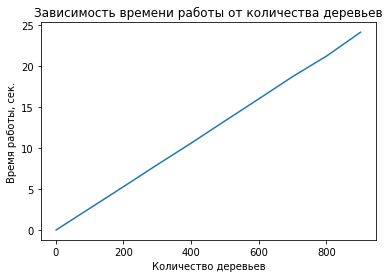

In [27]:
x_ticks = np.arange(1, 1001, 100)
plt.title('Зависимость времени работы от количества деревьев')
plt.xlabel('Количество деревьев')
plt.ylabel('Время работы, сек.')
plt.plot(x_ticks, time_results)
plt.savefig(fname='rf_n_estimators_time.pdf', format='pdf')

In [26]:
time_results

[0.027024507522583008,
 2.6756272315979004,
 5.331119775772095,
 8.015406847000122,
 10.644182682037354,
 13.354556322097778,
 16.044842958450317,
 18.758546352386475,
 21.259283304214478,
 24.15384268760681]

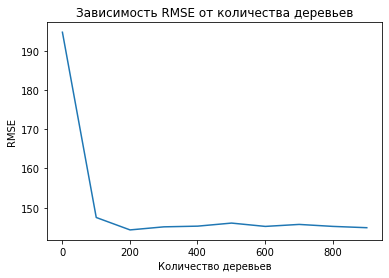

In [99]:
x_ticks = np.arange(1, 1001, 100)
plt.title('Зависимость RMSE от количества деревьев')
plt.xlabel('Количество деревьев')
plt.ylabel('RMSE')
plt.plot(x_ticks, results[1:1001:100])
plt.savefig(fname='rf_n_estimators.pdf', format='pdf')

Как видим, при числе деревьев >= 200, ошибка перестает значительно меняться и выходит на плато. В связи с этим, в дальнейших экспериментах будем брать 200 деревьев.

Теперь исследуем зависимость функции ошибки от глубины дерева (включая неограниченный вариант).

In [100]:
%%time
results = np.zeros(40)
for i in range(2, 30):
    rf = RandomForestMSE(n_estimators=200, max_depth=i)
    rf.fit(X_train, y_train)
    results[i] = RMSE(y_test, rf.predict(X_test))

Wall time: 3min


In [28]:
%%time
results = np.zeros(40)
time_results = []
for i in range(2, 30):
    start_time = time.time()
    rf = RandomForestMSE(n_estimators=200, max_depth=i)
    rf.fit(X_train, y_train)
    results[i] = RMSE(y_test, rf.predict(X_test))
    time_results.append(time.time() - start_time)

Wall time: 3min 11s


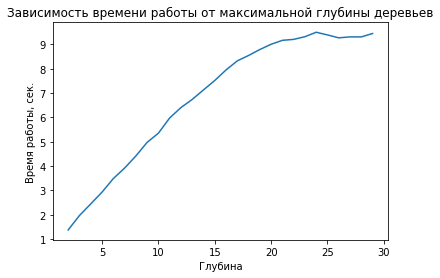

In [32]:
x_ticks = np.arange(2, 30)
plt.title('Зависимость времени работы от максимальной глубины деревьев')
plt.xlabel('Глубина')
plt.ylabel('Время работы, сек.')
plt.plot(x_ticks, time_results)
plt.savefig(fname='rf_max_depth_time.pdf', format='pdf')

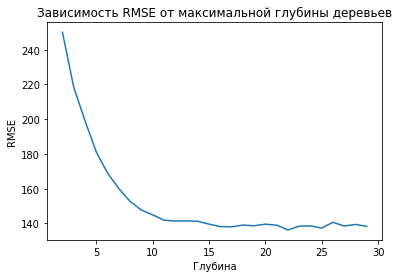

In [101]:
x_ticks = np.arange(2, 30)
plt.title('Зависимость RMSE от максимальной глубины деревьев')
plt.xlabel('Глубина')
plt.ylabel('RMSE')
plt.plot(x_ticks, results[2:30])
plt.savefig(fname='rf_max_depth.pdf', format='pdf')

Посмотрим численные значения.

In [104]:
sorted(list(results[2:30]))

[136.24763531579316,
 137.31739953907734,
 138.0207523889512,
 138.1879939149488,
 138.31559778931788,
 138.39761708577547,
 138.46821245211402,
 138.5797364793654,
 138.64349281539037,
 138.99310733805532,
 139.02490553541045,
 139.40846491866094,
 139.55852389483383,
 139.57861435833465,
 140.62839233671576,
 141.2629162470325,
 141.3724584658738,
 141.42084717877486,
 141.8626316874472,
 144.9370033513915,
 147.68651754955073,
 152.66489148967364,
 160.10719667262882,
 168.9791416964379,
 181.13258505348233,
 199.12662977724077,
 218.4826530407843,
 250.02403331413674]

Теперь посмотрим на ошибку алгоритма без ограничения на глубину.

In [103]:
rf = RandomForestMSE(n_estimators=200, max_depth=None)
rf.fit(X_train, y_train)
print(RMSE(y_test, rf.predict(X_test)))

138.45581828509114


Как видим, для слишком маленьких значений глубины, наша модель не будет являться досаточно гибкой, чтобы обнаружить сложные закономерности в данных. При глубине около 15, модель выходит на плато. Однако, как мы видим из численных показатей RMSE для моделей с ограничением глубины и без ограничения, эта зависимость не является монотонной. Стоит вспомнить, что чем выше больше глубина деревьев, тем больше наша модель переобучается. Если отключить максимальную глубину, то деревья будут очень переобученным, что (в нашем случае немного) уменьшает качество работы.

Наконец, посмотрим на зависимость ошибки от размера подмножества признаков, по которому в деревьях выбирается оптимальное разбиение.

In [106]:
print(f'Всего признаков: {X_train.shape[1]}')

Всего признаков: 17


In [108]:
%%time
results = np.zeros(20)
for i in range(2, 18):
    rf = RandomForestMSE(n_estimators=200, max_depth=15, feature_subsample_size=i)
    rf.fit(X_train, y_train)
    results[i] = RMSE(y_test, rf.predict(X_test))

Wall time: 2min 49s


In [33]:
%%time
results = np.zeros(20)
time_results = []
for i in range(2, 18):
    start_time = time.time()
    rf = RandomForestMSE(n_estimators=200, max_depth=15, feature_subsample_size=i)
    rf.fit(X_train, y_train)
    results[i] = RMSE(y_test, rf.predict(X_test))
    time_results.append(time.time() - start_time)

Wall time: 2min 50s


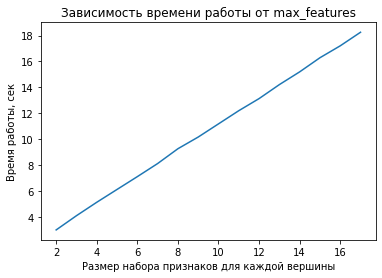

In [34]:
x_ticks = np.arange(2, 18)
plt.title('Зависимость времени работы от max_features')
plt.xlabel('Размер набора признаков для каждой вершины')
plt.ylabel('Время работы, сек')
plt.plot(x_ticks, time_results)
plt.savefig(fname='rf_max_features_time.pdf', format='pdf')

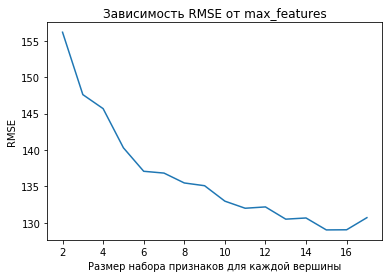

In [109]:
x_ticks = np.arange(2, 18)
plt.title('Зависимость RMSE от max_features')
plt.xlabel('Размер набора признаков для каждой вершины')
plt.ylabel('RMSE')
plt.plot(x_ticks, results[2:18])
plt.savefig(fname='rf_max_features.pdf', format='pdf')

## Градиентный бустинг

Базовая модель

In [9]:
gb = GradientBoostingMSE(n_estimators=100, max_depth=10)

In [10]:
%%time
gb.fit(X_train, y_train)

Wall time: 3.15 s


In [13]:
RMSE(y_test, gb.predict(X_test))

132.6012002148844

In [14]:
%%time
results = np.zeros(1001)
for i in range(1, 1001, 100):
    gb = GradientBoostingMSE(n_estimators=i, max_depth=10)
    gb.fit(X_train, y_train)
    results[i] = RMSE(y_test, gb.predict(X_test))

Wall time: 2min 20s


In [35]:
%%time
results = np.zeros(1001)
time_results = []
for i in range(1, 1001, 100):
    start_time = time.time()
    gb = GradientBoostingMSE(n_estimators=i, max_depth=10)
    gb.fit(X_train, y_train)
    results[i] = RMSE(y_test, gb.predict(X_test))
    time_results.append(time.time() - start_time)

Wall time: 2min 16s


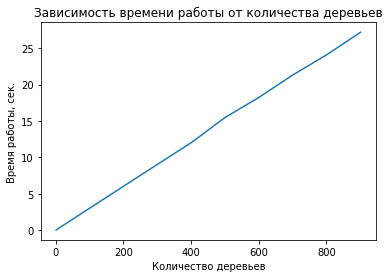

In [36]:
x_ticks = np.arange(1, 1001, 100)
plt.title('Зависимость времени работы от количества деревьев')
plt.xlabel('Количество деревьев')
plt.ylabel('Время работы, сек.')
plt.plot(x_ticks, time_results)
plt.savefig(fname='gb_n_estimators_time.pdf', format='pdf')

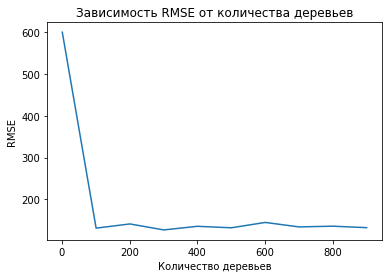

In [15]:
x_ticks = np.arange(1, 1001, 100)
plt.title('Зависимость RMSE от количества деревьев')
plt.xlabel('Количество деревьев')
plt.ylabel('RMSE')
plt.plot(x_ticks, results[1:1001:100])
plt.savefig(fname='gb_n_estimators.pdf', format='pdf')

In [19]:
results[1:1001:100]

array([599.76889057, 131.36503145, 141.38893878, 127.09480587,
       135.75116391, 132.17309889, 145.00013712, 134.26717012,
       136.02250274, 132.4719299 ])

In [16]:
gb = GradientBoostingMSE(n_estimators=5000, max_depth=10)
gb.fit(X_train, y_train)
RMSE(y_test, gb.predict(X_test))

137.8882676559845

In [17]:
gb = GradientBoostingMSE(n_estimators=10000, max_depth=10, learning_rate=1.0)
gb.fit(X_train, y_train)
RMSE(y_test, gb.predict(X_test))

197.95739957983685

In [40]:
%%time
time_results = []
results = np.zeros(40)
for i in range(2, 30):
    start_time = time.time()
    gb = GradientBoostingMSE(n_estimators=500, max_depth=i, learning_rate=0.1)
    gb.fit(X_train, y_train)
    results[i] = RMSE(y_test, gb.predict(X_test))
    time_results.append(time.time() - start_time)

Wall time: 9min 1s


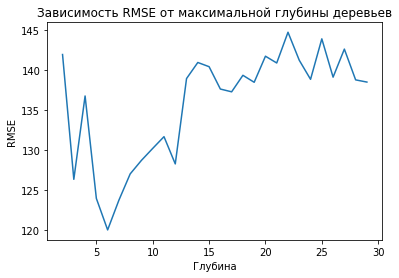

In [41]:
x_ticks = np.arange(2, 30)
plt.title('Зависимость RMSE от максимальной глубины деревьев')
plt.xlabel('Глубина')
plt.ylabel('RMSE')
plt.plot(x_ticks, results[2:30])
plt.savefig(fname='gb_max_depth2.pdf', format='pdf')

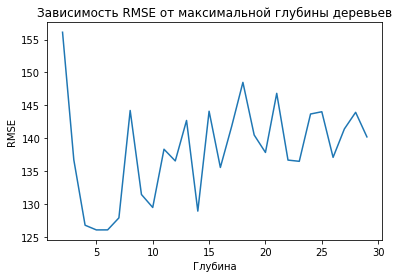

In [38]:
x_ticks = np.arange(2, 30)
plt.title('Зависимость RMSE от максимальной глубины деревьев')
plt.xlabel('Глубина')
plt.ylabel('RMSE')
plt.plot(x_ticks, results[2:30])
plt.savefig(fname='gb_max_depth.pdf', format='pdf')

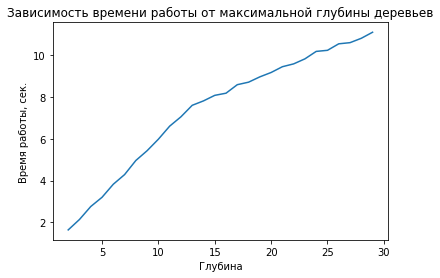

In [39]:
x_ticks = np.arange(2, 30)
plt.title('Зависимость времени работы от максимальной глубины деревьев')
plt.xlabel('Глубина')
plt.ylabel('Время работы, сек.')
plt.plot(x_ticks, time_results)
plt.savefig(fname='gb_max_depth_time.pdf', format='pdf')

In [22]:
results[2:30]

array([152.2342541 , 134.900616  , 127.12651617, 125.96124056,
       129.09466407, 129.18261231, 126.2219234 , 131.20559673,
       135.65636476, 138.35554781, 142.21441427, 139.94386191,
       145.54334523, 136.74219323, 142.23534486, 141.07774212,
       134.09677596, 147.0334428 , 150.29962565, 140.2835478 ,
       140.36179994, 137.34866997, 144.34643932, 145.2230479 ,
       135.6209862 , 132.6335881 , 133.68730628, 140.8179745 ])

In [42]:
%%time
time_results = []
results = np.zeros(20)
for i in range(2, 18):
    start_time = time.time()
    gb = GradientBoostingMSE(n_estimators=200, max_depth=15, feature_subsample_size=i)
    gb.fit(X_train, y_train)
    results[i] = RMSE(y_test, gb.predict(X_test))
    time_results.append(time.time() - start_time)

Wall time: 3min 16s


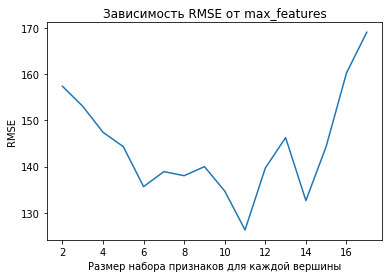

In [43]:
x_ticks = np.arange(2, 18)
plt.title('Зависимость RMSE от max_features')
plt.xlabel('Размер набора признаков для каждой вершины')
plt.ylabel('RMSE')
plt.plot(x_ticks, results[2:18])
plt.savefig(fname='gb_max_features.pdf', format='pdf')

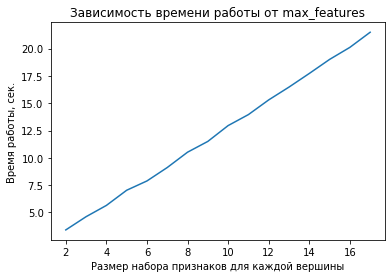

In [45]:
x_ticks = np.arange(2, 18)
plt.title('Зависимость времени работы от max_features')
plt.xlabel('Размер набора признаков для каждой вершины')
plt.ylabel('Время работы, сек.')
plt.plot(x_ticks, time_results)
plt.savefig(fname='gb_max_features_time.pdf', format='pdf')

In [56]:
%%time
time_results = []
params = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0]
results = np.zeros(20)
for i, x in enumerate(params):
    start_time = time.time()
    gb = GradientBoostingMSE(n_estimators=200, max_depth=15, learning_rate=x)
    gb.fit(X_train, y_train)
    results[i] = RMSE(y_test, gb.predict(X_test))
    time_results.append(time.time() - start_time)

Wall time: 57.3 s


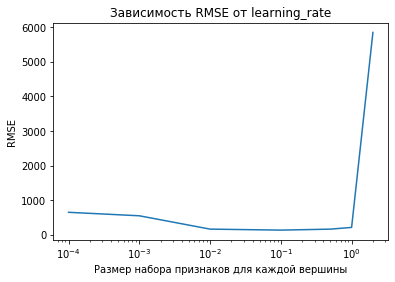

In [60]:
x_ticks = np.arange(2, 18)
plt.title('Зависимость RMSE от learning_rate')
plt.xlabel('Размер набора признаков для каждой вершины')
plt.ylabel('RMSE')
plt.xscale('log')
plt.plot(params, results[:7])
plt.savefig(fname='gb_learning_rate.pdf', format='pdf')

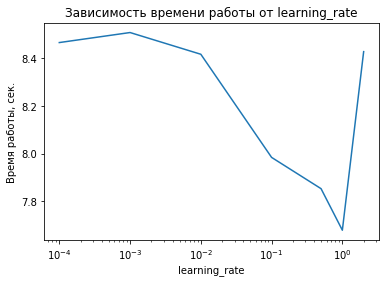

In [61]:
x_ticks = np.arange(2, 18)
plt.title('Зависимость времени работы от learning_rate')
plt.xlabel('learning_rate')
plt.ylabel('Время работы, сек.')
plt.plot(params, time_results)
plt.xscale('log')
plt.savefig(fname='gb_learning_rate_time.pdf', format='pdf')